In [1]:
import os
import sys
import numpy as np
import cv2 as cv2
from skimage.measure import regionprops
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os.path as path
import glob
import src.watershed_extraction as rinocell

import rinoutils
import plotutils


# Iterazione 2 esperimento #1


In [2]:
DATASET_PATH = "/home/prf/Desktop/UNI/TESI/Datasets/Dataset Iterazione 2/Immagini 1000X vetrini Citospin"
#DATASET_PATH = "/home/prf/Desktop/UNI/TESI/Datasets/Dataset iterazione 1/dataset_240718/palella"
rinoutils.display_dataset_metadata(DATASET_PATH, rinoutils.markdown_table_formatter)

|  ... |  ... |
| ------------- | ------------- |
| id | e9a682f03b620fea296f4bf64d963e38e417f443 |
| iterazione | 2 |
| data_acquisizione | 08/02/2019 |
| ora_acquisizone | 14:30:00 |
| luogo_acquisizione | Policlinico Bari |
| magnification_factor | 1000x |
| contenuto_vetrini | pap test |
| tecnica | citocentrifuga |
| colorazione | unknow |
| persone | ['Dott. Matteo Gelardi', 'Pio Raffaele Fina', 'Francesco Troccoli'] |

### Load dataset

scegliere un immagine da analizzare tra quelle presenti nel dataset indicando l'indice nella lista:

Chosed image:
/home/prf/Desktop/UNI/TESI/Datasets/Dataset Iterazione 2/Immagini 1000X vetrini Citospin/IMG01313.JPG


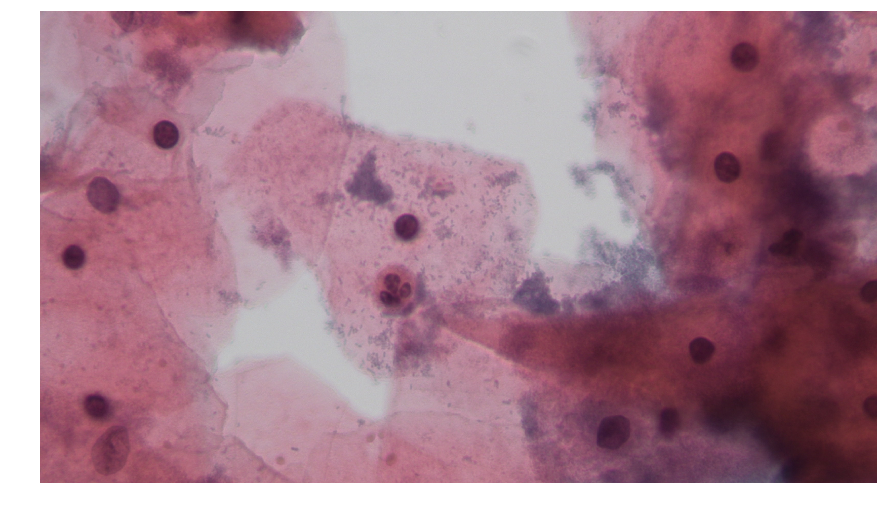

In [3]:
imgIndex = 25

#Select image
imgList = glob.glob(path.join(DATASET_PATH,"*JPG"))
imgList.extend( glob.glob(path.join(DATASET_PATH,"*jpeg")))
imgList.extend( glob.glob(path.join(DATASET_PATH,"*png")))

imgPath = imgList[imgIndex]
print("Chosed image:\n{}".format(imgPath))

#Show image
img = cv2.imread(imgPath)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

fig,ax = plt.subplots(figsize=(15,15))
ax.set_axis_off()
ax.imshow(img)
plt.show()

### Cell Detection

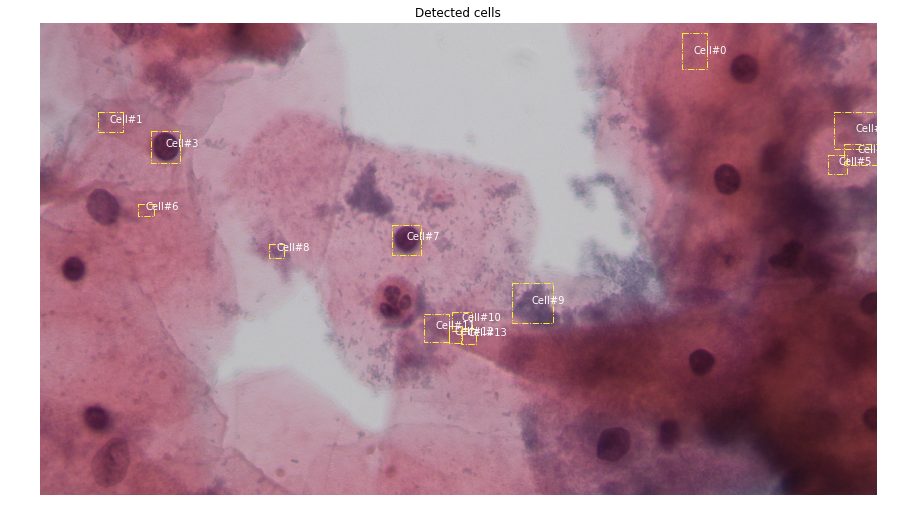

In [5]:
labels = rinocell.detect_cells(img)

#reset other annotations
ax.patches = []
ax.texts = []
ax.set_title("Detected cells")
plotutils.add_regions_annotations(labels,ax, plotutils.box_annotator, color="#FFEB3B", linewidth=1., linestyle="-.", fill=False)
plotutils.add_regions_annotations(labels,ax, plotutils.label_annotator, color="#FFFFFF")

fig

## Analisi


Come si può notare nell'immagine prodotta, molte cellule non sono state rilevate (*false negative*). Altre invece (es. cell \#0,#6,#8) sono state rilevate ma non sembrano essere cellule (*false positive*). La colorazione, sconosciuta in questi vetrini, non dovrebbe incidere sul processo di segmentazione:

> "Inoltre, la scelta di convertire l’immagine in scala di grigi rende l’algoritmo non dipendente dalla colorazione usata durante la preparazione del vetrino; ovvero, è possibile dare in input a questo software vetrini la cui colorazione è diversa dalla May-Grunwald-Giemsa." (Tesi Deperte)


#### Ipotesi
Per quanto riguarda i casi *false negative*, una possibile ipotesi del problema, potrebbe consistere nell'operazione di filtraggio (basata sulla dimensione) delle labels effettuata nel metodo 
` detect_cells`:

> "L’ultima fase della detections prevede che le labels della matrice siano filtrate: le cellule hanno più o meno tutte la stessa dimensione, quindi tra le labes ritrovate si escludono quelle troppo piccole o troppo grandi.
All’inizio di questa sperimentazione, dopo numerose prove, si è stabilito empiricamente un range per la dimensione delle cellule. La precisione si è raggiunta solo dopo aver utilizzato un micrometro, descritto nel Capitolo 2.6. Grazie a questo strumento è stato possibile verificare che la dimensione di una cellula varia da un minimo di 30000 px2 ad un massimo di 90000 px2. Tenendo in considerazione questi valori nel software le sue prestazioni sono nettamente migliorate, come è spiegato nel Capitolo 4.4."

Per i casi *false positive*, la situazione risulta essere più complessa, da una prima analisi non è chiaro il motivo per cui aree dell'immagine "piatte" siano state rilevate come cellule. Segue un'ulteriore analisi nella quale verranno esplicitati i singoli passi dell'algoritmo di *cell detection* per cercare di ottenere insight sul problema